In [10]:
import os

import tdt
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

from fptools.preprocess import trim_signals, detrend_double_exponential, estimate_motion, zscore_signals
from fptools.viz import plot_signal_at_events, plot_heatmap

In [2]:
block = tdt.read_block(r'M:\2024 July,Aug GRABDA2m data (DLS C1906Y)\Progressive Ratio tanks\PR day 1 WT\EN145_PRD1-240819-144327')
block

read from t=0s to t=3599.21s


epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])

In [9]:
block.info

tankpath:	'M:\\2024 July,Aug GRABDA2m data (DLS C1906Y)\\Progressive Ratio tanks\\PR day 1 WT'
blockname:	'EN145_PRD1-240819-144327'
start_date:	datetime.datetime(2024, 8, 19, 14, 43, 32, 999999)
utc_start_time:	'14:43:32'
stop_date:	datetime.datetime(2024, 8, 19, 15, 43, 32, 210963)
utc_stop_time:	'15:43:32'
duration:	datetime.timedelta(seconds=3599, microseconds=210964)
stream_channel:	0
snip_channel:	0

In [15]:



def preprocess(block, show_steps=True, cache=True):
    cache_path = os.path.join('cache', f'{block.info.blockname}.npz')
    if cache and os.path.exists(cache_path):
        print(f'loading cache: "{cache_path}"')
        with np.load(cache_path) as data:
            return data['time'], data['dopa'], data['isob']
    else:
        sampling_rate = block.streams['_465A'].fs
        dopa = block.streams['_465A'].data
        isob = block.streams['_415A'].data
        time = np.linspace(1,len(dopa), len(dopa)) / sampling_rate

        if show_steps:
            fig, axs = plt.subplots(6, 1, figsize=(24, 6*6))

            axs[0].plot(time, dopa, label='Dopamine', c='g')
            axs[0].plot(time, isob, label='Isosbestic', c='r')
            axs[0].set_title('Raw signal')
            axs[0].legend()

        # trim raw signal start to when the optical system came online
        dopa_trimmed, isob_trimmed, time_trimmed = trim_signals(dopa, isob, time, begin=int(block.scalars.Fi1i.ts[0] * sampling_rate))

        if show_steps:
            axs[1].plot(time_trimmed, dopa_trimmed, label='Dopamine', c='g')
            axs[1].plot(time_trimmed, isob_trimmed, label='Isosbestic', c='r')
            axs[1].set_title('Trimmed Raw signal')
            axs[1].legend()

        # detrend using a double exponential fit
        dopa_detrend, dopa_fit = detrend_double_exponential(time_trimmed, dopa_trimmed)
        isob_detrend, isob_fit = detrend_double_exponential(time_trimmed, isob_trimmed)

        if show_steps:
            axs[2].plot(time_trimmed, dopa_trimmed, label='Dopamine', c='g')
            axs[2].plot(time_trimmed, dopa_fit, label='Dbl Exp Fit', c='k')
            axs[2].plot(time_trimmed, isob_trimmed, label='Isosbestic', c='r')
            axs[2].plot(time_trimmed, isob_fit, label='Dbl Exp Fit', c='k')
            axs[2].set_title('Double Exponential Fit')
            axs[2].legend()

            axs[3].plot(time_trimmed, dopa_detrend, label='Dopamine', c='g')
            axs[3].plot(time_trimmed, isob_detrend, label='Isosbestic', c='r')
            axs[3].set_title('De-trended signals')
            axs[3].legend()

        # correct for motion artifacts
        dopa_motion_corrected, est_motion = estimate_motion(dopa_detrend, isob_detrend)

        if show_steps:
            axs[4].plot(time_trimmed, dopa_motion_corrected, label='Dopamine', c='g')
            axs[4].plot(time_trimmed, est_motion, label='Estimated Motion', c='b')
            axs[4].set_title('Motion Correction')
            axs[4].legend()

        #dopa, isob = zscore_signals(dopa, isob)
        # computed deltaF / F
        dopa_norm = 100 * dopa_motion_corrected / dopa_fit

        if show_steps:
            axs[5].plot(time_trimmed, dopa_norm, label='Dopamine', c='g')
            axs[5].set_title('Normalized')
            axs[5].legend()

        if cache:
            np.savez_compressed(cache_path, time=time_trimmed, dopa=dopa_norm, isob=isob_detrend)

        return time_trimmed, dopa_norm, isob_detrend

In [16]:
time, dopa, isob = preprocess(block, cache=True)

loading cache: "cache\EN145_PRD1-240819-144327.npz"


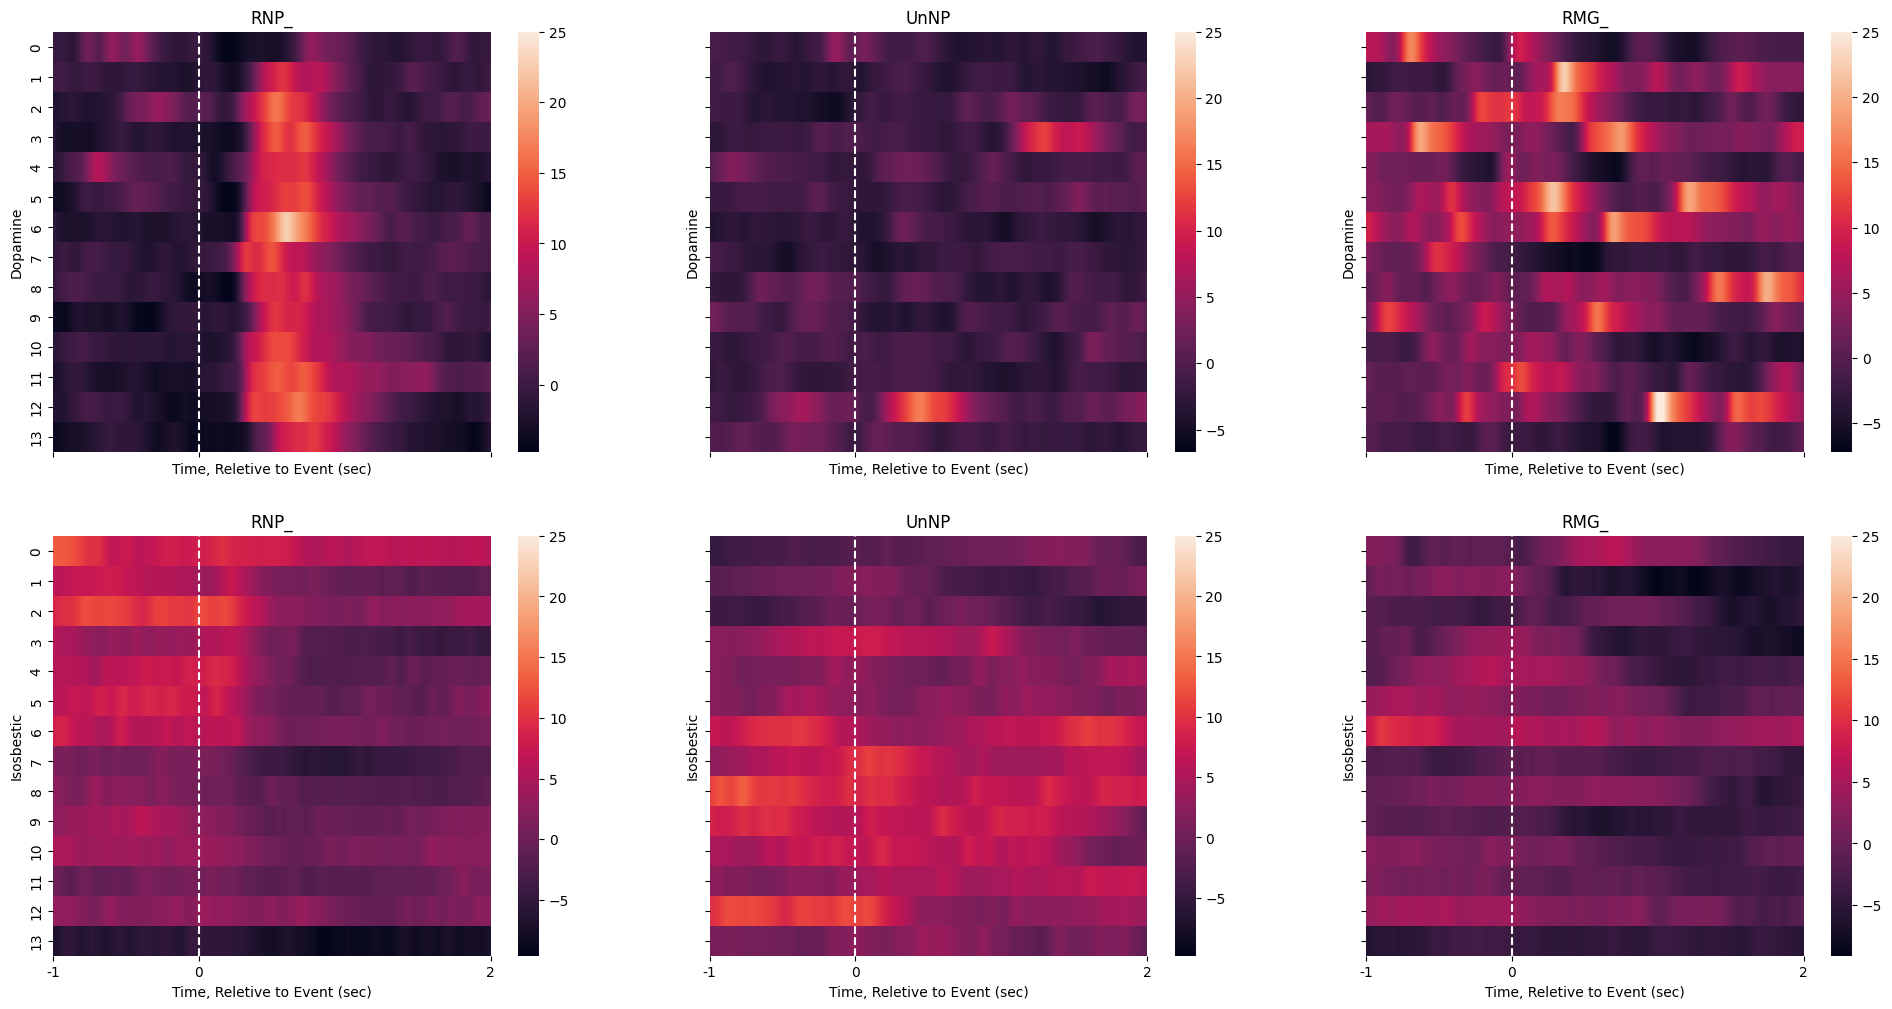

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(24, 12), sharey=True, sharex=True)

for i, e in enumerate(['RNP_', 'UnNP', 'RMG_']):
    for j, (label, signal) in enumerate([('Dopamine', dopa), ('Isosbestic', isob)]):
        ax = axs[j, i]
        plot_heatmap(block.epocs[e].onset, signal, time, ax=ax, vmax=25)
        ax.set_ylabel(label)
        ax.set_title(e)

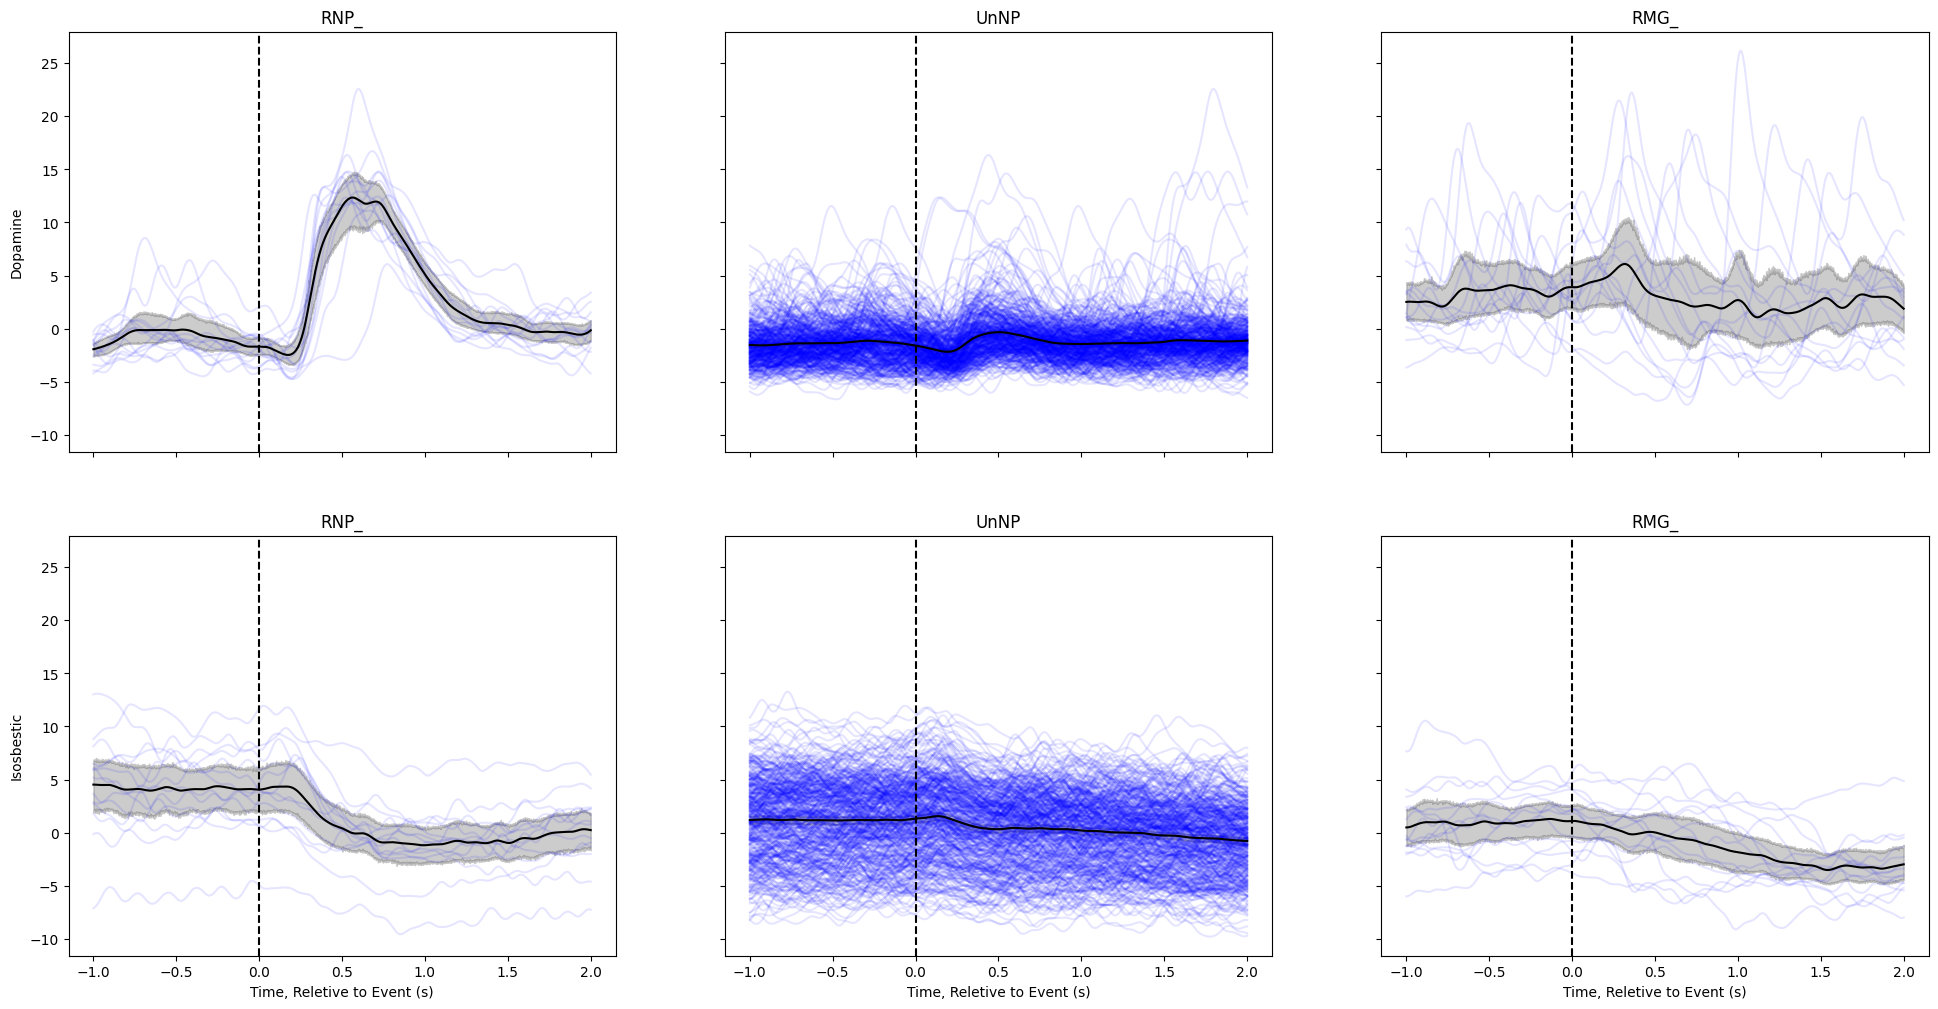

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(24, 12), sharey=True, sharex=True)

for i, e in enumerate(['RNP_', 'UnNP', 'RMG_']):
    for j, (label, signal) in enumerate([('Dopamine', dopa), ('Isosbestic', isob)]):
        ax = axs[j, i]
        plot_signal_at_events(block.epocs[e].onset, signal, time, ax=ax)
        ax.set_ylabel(label)
        ax.set_title(e)